In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from ddpm import *


/nethome/zwang910/file_storage/miniconda3/envs/dl/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# 1. Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
lr = 1e-4
num_epochs = 50
num_timesteps = 1000

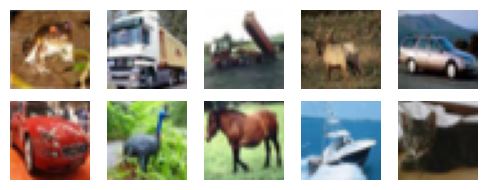

In [15]:
# load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.CenterCrop(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
# display first 10 images
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
    img, _ = dataset[i]
    # print(img)
    axes[i//5, i%5].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

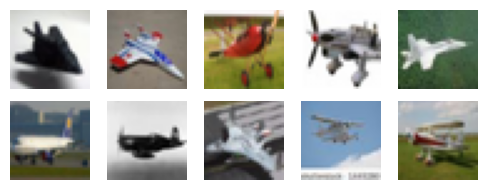

In [16]:
# only extract class 1
class_1_indices = [i for i, (_, label) in enumerate(dataset) if label == 0]
class_1_dataset = torch.utils.data.Subset(dataset, class_1_indices)
class_1_loader = DataLoader(class_1_dataset, batch_size=128, shuffle=True)
# dis play first 10 images of class 1
fig, axes = plt.subplots(2, 5, figsize=(5, 2))
for i in range(10):
    img, _ = class_1_dataset[i]
    axes[i//5, i%5].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)
    axes[i//5, i%5].axis('off')
plt.tight_layout()
plt.show()

# Train DDPM

In [12]:
# instantiate scheduler and UNet
scheduler = NoiseScheduler(timesteps=1000, device=device, beta_schedule="linear")
unet = UNet2DModel(
    sample_size=32,         # CIFAR-10 image size
    in_channels=3,
    out_channels=3,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    layers_per_block=2,
    norm_num_groups=32
)
ddpm = DDPM(unet, scheduler, device=device)

Epoch 1/2000:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/2000:  98%|█████████▊| 39/40 [00:05<00:00,  7.07it/s, loss=0.0286]

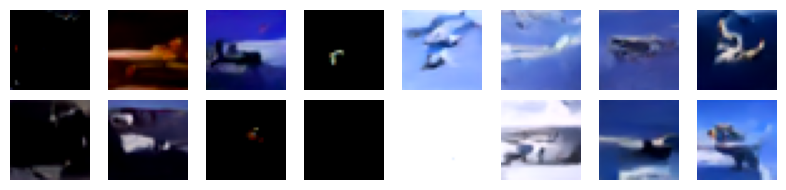

Epoch 50/2000:  98%|█████████▊| 39/40 [00:05<00:00,  7.06it/s, loss=0.0248]

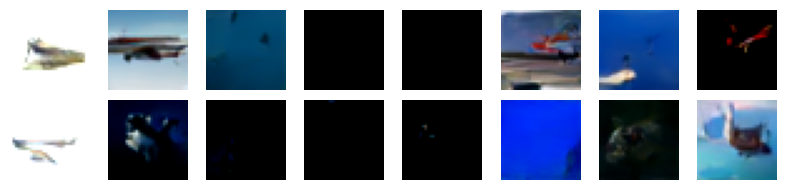

Epoch 75/2000:  98%|█████████▊| 39/40 [00:05<00:00,  6.93it/s, loss=0.0234]

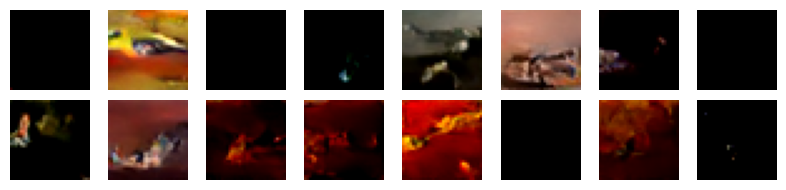

Epoch 100/2000:  98%|█████████▊| 39/40 [00:05<00:00,  7.05it/s, loss=0.0265]

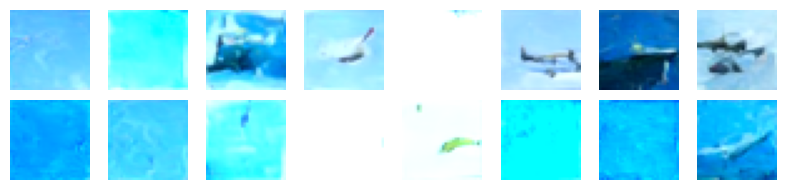

Epoch 125/2000:  98%|█████████▊| 39/40 [00:05<00:00,  7.04it/s, loss=0.0254]

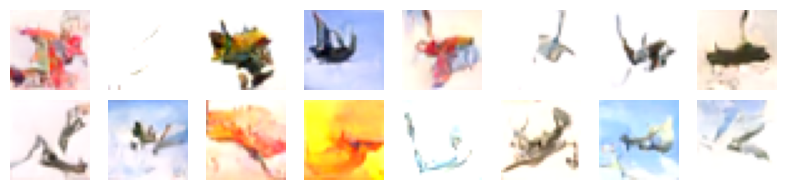

Epoch 150/2000:  98%|█████████▊| 39/40 [00:05<00:00,  6.99it/s, loss=0.0316]

In [ ]:
optimizer = torch.optim.Adam(ddpm.unet.parameters(), lr=2e-4, weight_decay=1e-5)
num_epochs = 2000
step = 0

for epoch in range(1, num_epochs+1):
    ddpm.train()
    pbar = tqdm(class_1_loader, desc=f"Epoch {epoch}/{num_epochs}")
    avg_loss = 0.0
    for imgs, _ in pbar:
        imgs = imgs.to(device)
        # loss = ddpm.training_loss(imgs)
        pred_noise, noise = ddpm(imgs, y=None)
        loss = F.mse_loss(pred_noise, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss = avg_loss * 0.9 + loss.item() * 0.1
        pbar.set_postfix(loss=avg_loss)
        step += 1
        # optional: save a checkpoint every few epochs
        if step % 1000 == 0:
            # 5) Sampling example
            ddpm.eval()
            samples = ddpm.sample(num_samples_per_label=16)  # [0,1] images
            # display samples
            fig, axes = plt.subplots(2, 8, figsize=(8, 2))
            for i in range(16):
                axes[i//8, i%8].imshow(samples[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5)
                axes[i//8, i%8].axis('off')
            plt.tight_layout()
            plt.show()

    ddpm.train()